# Remove Image Backgrounds with Python

### Tutorial by _Tobias Reaper_

---

### Notes

* Please do not request access to this tutorial. You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself.


### Resources and related content

* [Trash Panda](https://tobias.fyi/workshop/trash-panda/)
* [Two Shots to Green Screen: Collage with Deep Learning](https://app.wandb.ai/stacey/greenscreen/reports/Two-Shots-to-Green-Screen%3A-Collage-with-Deep-Learning--VmlldzoxMDc4MjY)



---
---

## Introduction

### TL;DR

The goal of this tutorial is to describe a possible method of creating binary masks for one or more objects in an image by using an image segmentation (computer vision) model.

Rather than drawing binary masks completely by hand or use proprietary software like Photoshop I will show you how to automate the process using completely free, open-source tools. Namely, we will be using Python along with a few open-source libraries such as NumPy, OpenCV (opencv-python), and PyTorch. Don't get intimidated by the names or the libraries—the process really just comes down to writing a function.

---
---

## Setup

### Install detectron2 and other dependencies

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.5.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (colab has CUDA 10.1 + torch 1.5)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.5")
!pip install detectron2==0.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.9MB 643kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200715-cp36-none-any.whl size=42315 sha256=bdedbe647787be9f7bbcc632fd7c711d7f60f2a358efc9a340a9da44219cb5d5
  Stored in directory: /root/.cache/pip/wheels/08/da/7c/5f1b4549b59c285c1e1c6b2cc8a59595dc33aec197752d5778
Successfully built fvcore


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download the image from the GitHub permalink:

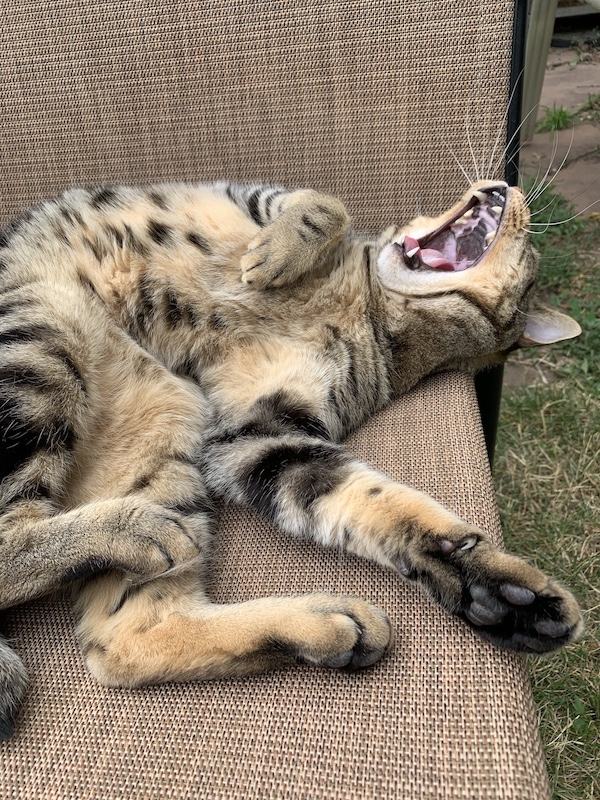

In [4]:
# === Download and load image === #
!wget https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/01_hobbes.jpg -q -O 01_hobbes.jpg
im = cv2.imread("./01_hobbes.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:18, 9.51MB/s]                           


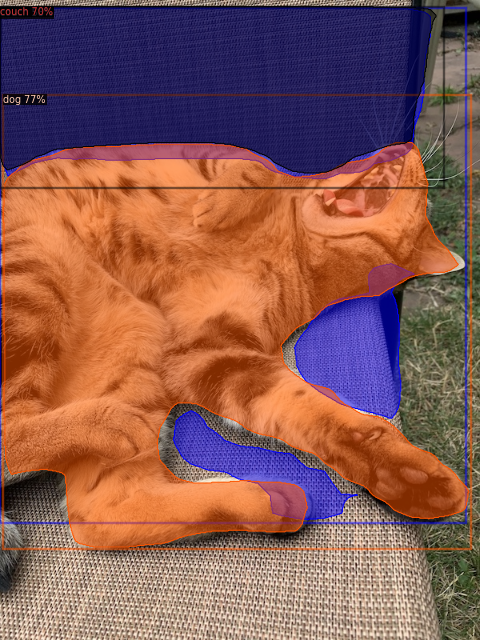

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Those colored areas are the "masks", which can be extracted from the output of the model and used to manipulate the image in neat ways. First, we'll need to get the array(s) holding the mask(s).

In this case, as can be seen below, each mask is a 2-dimensional array of Boolean values, each one representing a pixel. If a pixel is

In [7]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_masks)

tensor([16, 57, 57], device='cuda:0')
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False, 

In [8]:
# Find out what the classes are

# List of all classes in training dataset (COCO)
# predictor.metadata.as_dict()["thing_classes"]

# The one we are interested in
predictor.metadata.as_dict()["thing_classes"][16]

'dog'

The "dog" is the first id in the `.pred_classes` list. Therefore, the mask that we want is the first one in the `.pred_masks` list.

In [9]:
# Extract the mask of Hobbes
mask_tensor = outputs["instances"].pred_masks[0]
print(mask_tensor.shape)
mask_tensor

torch.Size([800, 600])


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

In [10]:
# Convert tensor to numpy array
hobbes_mask = mask_tensor.cpu()
print(hobbes_mask.shape)
hobbes_mask

torch.Size([800, 600])


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [11]:
# Looks good!
np.array(hobbes_mask)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

---

### Create a Binary Mask

Now that we've run inference on the image and retrieved the mask array, it's time to turn that array into a binary mask. While I won't be using this particular binary mask directly, it can be downloaded as a png and/or edited and used to various ends.

In [12]:
# Create blank black background
# The "True" pixels will be converted to white and copied onto the black background
background = np.zeros(hobbes_mask.shape)
background.shape

(800, 600)

In [13]:
# Add white pixels where mask values are True
bin_mask = np.where(hobbes_mask, 255, background).astype(np.uint8)
print(bin_mask.shape)
bin_mask

(800, 600)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

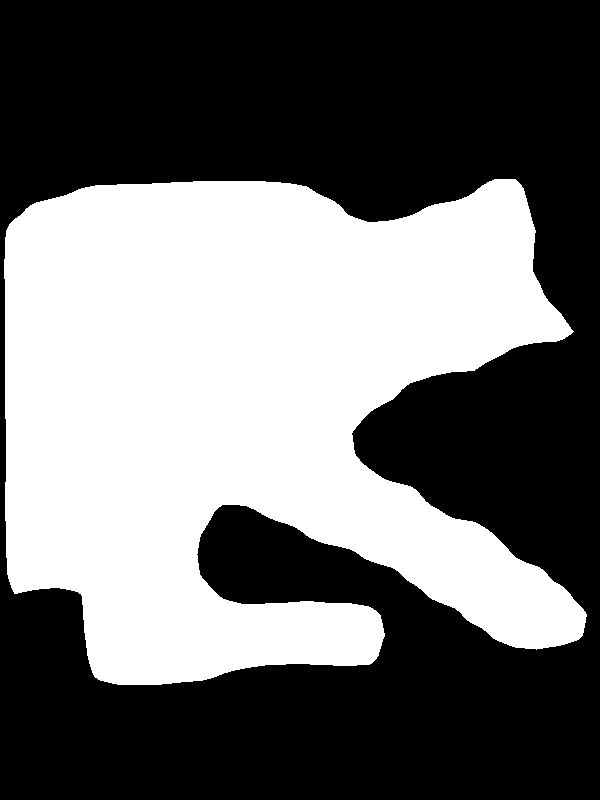

In [14]:
# Show the resulting binary mask
cv2_imshow(bin_mask)

---

### Use the Binary Mask

Use the mask to manipulate the image.

In order to use numpy operations between the mask and image, the dimensions of the mask must match the image. The image array has three values for each pixel, indicating the values of red, green, and blue (RGB) that the pixel should render. Therefore, the mask must also have three values for each pixel. To do this, I used a NumPy method called `np.stack` to basically "stack" three of the masks on top of one another.

>  `numpy.stack(arrays, axis=0, out=None)`  
> Join a sequence of arrays along a new axis.

Once the dimensions match, another NumPy method, `np.where`, can be used to copy or extract only the pixels contained within the area of the mask.

I created a blank black background onto which those pixels can be copied. This may not be the best way to go about this process. However, from some basic research, it seemed to me that adding the alpha channel to the original image first had its own set of issues and complexities.

In [41]:
# === Add a fourth channel to the original image array === #

# Split into RGB (technically BGR in OpenCV) channels
b, g, r = cv2.split(im.astype("uint8"))

# Create alpha channel array of ones
# Then multiply by 255 to get the max transparency value
a = np.ones(hobbes_mask.shape, dtype="uint8") * 255

print(b.shape, g.shape, r.shape, a.shape)

(800, 600) (800, 600) (800, 600) (800, 600)


In [42]:
a

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

(800, 600, 4)


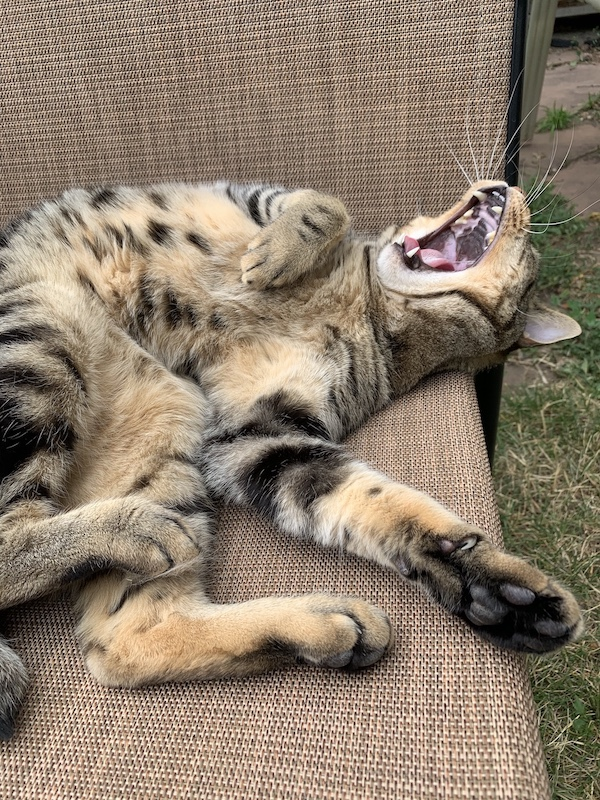

In [44]:
# Rejoin with alpha channel that's always 1, or non-transparent
rgba = [b, g, r, a]
im_4ch = cv2.merge(rgba, 4)
# im_4ch = np.stack([b, g, r, a], axis=2)

print(im_4ch.shape)
cv2_imshow(im_4ch)

In [45]:
# Create 4-channel black background
bg = np.zeros(im_4ch.shape)
bg.shape

(800, 600, 4)

In [46]:
# Create 4-channel mask
mask = np.stack([hobbes_mask, hobbes_mask, hobbes_mask, hobbes_mask], axis=2)

In [47]:
# Copy color pixels from the original color image where mask is set
foreground = np.where(mask, im_4ch, bg).astype(np.uint8)

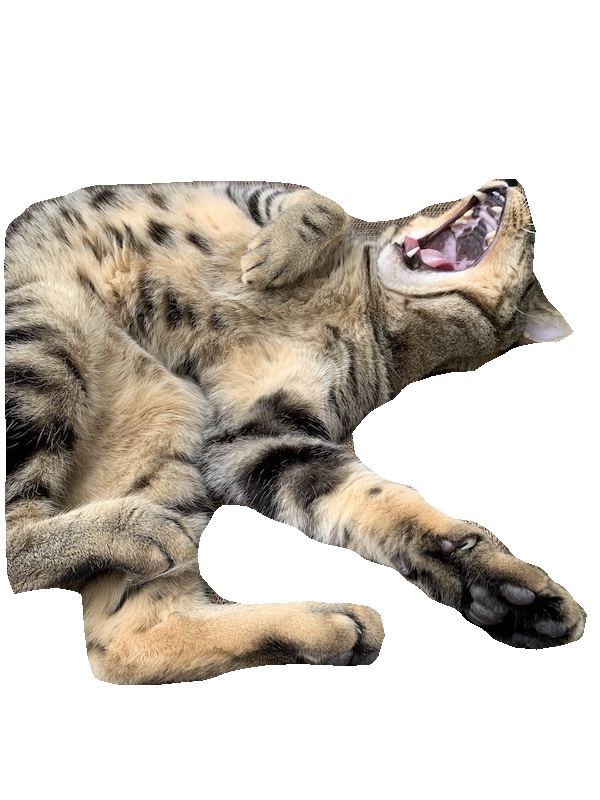

In [48]:
# Check out the result
cv2_imshow(foreground)

---

#### The Roundabout Method

This is how I added a fourth channel to the image after the fact, once the colored pixels had been copied onto a black background. While this method works, I'm sure you can think of one primary issue with it. It took me too long to realize this, but by using a black background and the method below, which converts all black pixels to transparent, any pixels brought over from the original image that also happened to be black were converted to transparent.

That's why I decided to refactor into the method above.

In [ ]:
# Create a blank black 3-channel background
bg = np.zeros(im.shape)
bg.shape

(800, 600, 4)

In [ ]:
# Create 3-channel mask
mask = np.stack([hobbes_mask, hobbes_mask, hobbes_mask], axis=2)

In [ ]:
# Copy color pixels from the original color image where mask is set
foreground = np.where(mask, im, bg).astype(np.uint8)

In [ ]:
# Convert to 4-channel image
# i.e. add the alpha channel and convert black pixels to alpha
tmp = cv2.cvtColor(foreground.astype("uint8"), cv2.COLOR_BGR2GRAY)
_, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
b, g, r = cv2.split(foreground.astype("uint8"))
rgba = [b, g, r, alpha]
dst2 = cv2.merge(rgba, 4)
# Look at the result, if needed
# cv2_imshow(dst2)

---

## Final Thoughts

Now, this image can be saved (as a PNG to preserve the alpha channel/transparency) and simply overlayed onto another image.

What a masterpiece!

<img src="https://raw.githubusercontent.com/tobias-fyi/assetstash/master/visual/images/img_seg_bin_mask/06_hawbbes.jpg" height=500/>